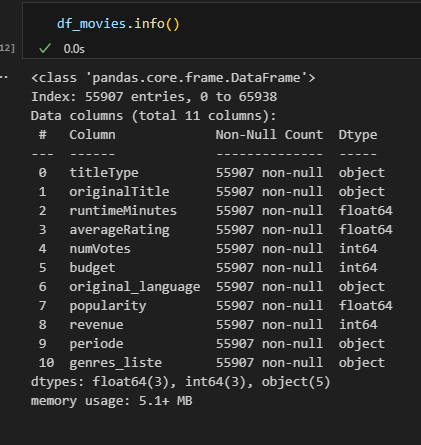

In [ ]:
def choix_film(titre):
    liste = df_movies[df_movies["originalTitle"]== titre]["genres_liste"].iloc[0] #Nous faisons une liste des genres du film en question
    df_movies_genre = df_movies[df_movies['genres_liste'].apply(lambda x: any(genre in x for genre in liste))].copy() #Nous faisons un nouveau DataFrame avec uniquement les films dont la liste de genres a au moins un genre commun avec le film initial.
    #(any() permet de vérifier s'il y a au moins un genre de la liste)

#On va ensuite crée des nouvelles colonnes avec des valeurs booléennes pour chaque genre de la colonne genres_listes.
    tous_les_genres = set()
    for genres in df_movies_genre['genres_liste']:
      tous_les_genres.update(genres)
    for genres in tous_les_genres:
      df_movies_genre[f'genre_{genres}'] = df_movies_genre['genres_liste'].apply(lambda x: genres in x)

    df_movies_genre = df_movies_genre.drop(['genres_liste'], axis = 1) #On peut ensuite supprimer la colonne genres_listes.
    df_movies_bool = df_movies_genre.select_dtypes(include='bool') #On crée un df avec uniquement les colonnes booléennes
    df_movies_X = df_movies_genre.drop(['originalTitle'], axis = 1) #On crée le df_movies_X (sans le titre) qu’on va appliquer dans la fonction encodage_X.


    def encodage_X(X, type='standard'): #Fonction encodage
      index = X.index
      X_num = X.select_dtypes('number')
      X_cat = X.select_dtypes(['object', 'category', 'string'])


      if type == 'standard':
        from sklearn.preprocessing import StandardScaler
        SN = StandardScaler()
        X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns, index=index)

      else:
        from sklearn.preprocessing import MinMaxScaler
        SN = MinMaxScaler()
        X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns, index=index)

      X_cat_dummies = pd.get_dummies(X_cat)
      X_encoded = pd.concat([X_num_SN, X_cat_dummies], axis=1)

      return X_encoded, SN


    X_encoded, SN = encodage_X(df_movies_X, type = "normal") #On fait une normalisation
    X_encoded =pd.concat([X_encoded, df_movies_bool], axis=1) #Les colonnes booléennes ne sont plus présentes, on les rajoure avec pd.concat (l'index n'a pas bougé)

    from sklearn.neighbors import NearestNeighbors #On utilise la classification des plus proches voisins
    nn = NearestNeighbors(n_neighbors=5, metric='euclidean') #On prend les 5 plus proches (le premier sera forcément le film en question)
    nn.fit(X_encoded)


    def encodage_predict(df_a_predire): #Fonction encodage predict
      X_num = df_a_predire.select_dtypes('number')
      X_cat = df_a_predire.select_dtypes(['object', 'category', 'string'])



      X_num_SN = pd.DataFrame(SN.transform(X_num), columns=X_num.columns).reset_index(drop=True)

      X_cat_dummies = pd.get_dummies(X_cat).reset_index(drop=True)
      X_encoded_predire = pd.concat([X_num_SN, X_cat_dummies], axis=1)

      df_predict = X_encoded_predire

      # DataFrame vide qui a les mêmes colonnes que X_encoded
      df_final = pd.DataFrame(columns=X_encoded.columns)

      # On veut que le DataFrame ait le même nombre de lignes que df_predict
      df_final = df_final.reindex(index=df_predict.index)
      # On met tous les NaN à False
      df_final = df_final.fillna(False)

      # On parcourt chaque colonne de df_predict
      # Si la colonne est présente dans X_encoded alors on la garde
      # Sinon, on la met à False
      for column in df_predict.columns:
        if column in X_encoded.columns:
          df_final[column] = df_predict[column]

      return df_final


    df_movies_film = df_movies_genre[df_movies_genre["originalTitle"]==titre] #On fait un df avec uniquement la ligne du film choisi
    df_movies_film  = df_movies_film.drop(columns = "originalTitle") #On supprime la colonne titre
    df_movies_bool_film = df_movies_film.select_dtypes(include='bool') #On crée un df avec uniquement les colonnes booléennes
    df_movies_bool_film = df_movies_bool_film.reset_index(drop=True) #On réinitialise les indices du df avec les colonnes booléennes
    film_encodage = encodage_predict(df_movies_film ) #On applique la fonction
    colonnes = [col for col in film_encodage.columns if col.startswith('genre_')] #La fonction encodage prédict nous a crée des colonnes pour chaque genre qui ne sont pas exactes
    film_encodage = film_encodage.drop(columns = colonnes) #On va donc supprimer chaque colonne qui commence par « genre_ »
    film_encodage = film_encodage.reset_index(drop=True) #On réinitialise les indices du df avant de faire le pd.concat
    film_encodage =pd.concat([film_encodage, df_movies_bool_film], axis=1) #On concat les df
    distances, indices = nn.kneighbors(film_encodage) #On peut alors prédire les similarités
    return df_movies_genre.iloc[indices[0,1:]] #On exclut le premier car le film le plus proche est forcément le film lui-même


film = choix_film("Avatar")
film